In [58]:
import numpy as np
import scipy.io as sio
from scipy.integrate import solve_ivp
import scipy as sp
import matplotlib.pyplot as mpl
import pymc as pm
import arviz as az
import pandas as pd
import os
from datetime import datetime
import sys
from math import atan,cos,sin
from vd_class import vd_8dof
from point import Point

### Set up vehicle model for steering test

In [59]:
# A ramp steer
pt1 = Point(0,0)
pt2 = Point(3.7,0.2)
ramp_st_3 = pt1.get_eq(pt2)

# Used for obtaining the state from the chrono vehicle
n1  = 700
n2 = 1070


# The time duration of the simulation
st_time = 0.
end_time = 3.7


# The times for which we want the simulation
time  = np.arange(st_time,end_time,0.01)
t_eval = np.arange(st_time,end_time,0.01)

def zero_throt(t):
    return 0 * t
def brake_tor(t):
    return 0 * t

state = pd.read_csv("simp_ramp.csv",sep=',',header='infer')

st = {'x' : state['x'][n1]-state['x'][n1],'y':state['y'][n1]-state['y'][n1],'u':state['vx'][n1],
'v':state['vy'][n1],'psi':state['yaw'][n1],'phi':state['roll'][n1],'wx':state['roll_rate'][n1],
'wz':state['yaw_rate'][n1],'wlf' : state['wlf'][n1],'wlr' : state['wlr'][n1],'wrf' : state['wrf'][n1],'wrr' : state['wrr'][n1]}

vehicle = vd_8dof(states = st)

# Set the steering and the throttle functions we just created above
vehicle.set_steering(ramp_st_3)
vehicle.set_throttle(zero_throt,gr=0.3*0.2)
vehicle.set_braking(brake_tor)
vehicle.debug = 0

/home/huzaifa/research/tutorials/vd_class.py:1096: UserWarning: Set parameters to default values
{'a': 1.14, 'b': 1.4, 'Cf': 44000, 'Cr': 47000, 'Cxf': 5000, 'Cxr': 5000, 'm': 1400, 'Jz': 2420, 'r0': 0.285, 'Jw': 2, 'Jx': 900, 'Jy': 2000, 'Jxz': 90, 'h': 0.75, 'cf': 1.5, 'cr': 1.5, 'muf': 80, 'mur': 80, 'ktf': 200000, 'ktr': 200000, 'hrcf': 0.65, 'hrcr': 0.6, 'krof': 29000, 'kror': 29000, 'brof': 3000, 'bror': 3000, 'rr': 0.0125}
  warnings.warn("Set parameters to default values" +


### Get the chain and load the files

In [60]:
# The chain file
# filename = "20220608_031039"
filename = "20220611_230716"
idata = az.from_netcdf('./results/' + filename + ".nc")
dataFileName = "vd_chrono_ramp_1.npy"
##The data in npy format
with open(dataFileName, 'rb') as f:
    data = np.load(f)


In [82]:
save = True

### Set up the posteriors and the priors on parameters of interest

In [83]:
shape = idata['posterior']['Cf'].shape

posterior_Cf = np.asarray(idata['posterior']['Cf']).reshape(shape[0]*shape[1],)
posterior_Cr = np.asarray(idata['posterior']['Cr']).reshape(shape[0]*shape[1],)
posterior_krof = np.asarray(idata['posterior']['krof']).reshape(shape[0]*shape[1],)
posterior_kror =np.asarray(idata['posterior']['kror']).reshape(shape[0]*shape[1],)
posterior_brof = np.asarray(idata['posterior']['brof']).reshape(shape[0]*shape[1],)
posterior_bror =np.asarray(idata['posterior']['bror']).reshape(shape[0]*shape[1],)


prior_Cf = np.random.uniform(low=20000,high=80000,size=(shape[0]*shape[1]),)
prior_Cr = np.random.uniform(low=20000,high=80000,size=(shape[0]*shape[1]),)
prior_krof = np.random.uniform(low=1000,high=50000,size=(shape[0]*shape[1]),)
prior_kror = np.random.uniform(low=1000,high=50000,size=(shape[0]*shape[1]),)
# prior_kro = np.random.uniform(low=2000,high=100000,size=(shape[0]*shape[1]),)
# prior_krof = prior_kro/2
# prior_kror = prior_kro/2

# prior_brof = np.random.uniform(low=100,high=30000,size=(shape[0]*shape[1]),)
# prior_bror = np.random.uniform(low=100,high=30000,size=(shape[0]*shape[1]),)
prior_bro = np.random.uniform(low=200,high=60000,size=(shape[0]*shape[1]),)
prior_brof = prior_bro/2
prior_bror = prior_bro/2

### Sample from the posterior

In [84]:
#Number of posterior samples
no_post = 100


random_points = np.random.randint(low=0,high=shape[0]*shape[1],size=(no_post,),dtype=int)

#The posterior lines
posterior_LV = np.empty((no_post,time.shape[0]))
posterior_YW = np.empty((no_post,time.shape[0]))
posterior_RA = np.empty((no_post,time.shape[0]))
posterior_RR = np.empty((no_post,time.shape[0]))

for i in range(0,no_post):
    vehicle.update_params(Cf=posterior_Cf[random_points[i]],
                      Cr = posterior_Cr[random_points[i]],krof = posterior_krof[random_points[i]],kror = posterior_kror[random_points[i]],
                      brof = posterior_brof[random_points[i]],bror = posterior_bror[random_points[i]],
                         m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,
                          cr = 1.82,Jx = 1289,Jz = 4519,Jxz = 3.265,r0=0.47,ktf=326332,ktr=326332,
                          hrcf=0.379,hrcr=0.327,Jw=11,Cxf = 17700,Cxr = 17700)
    mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 1e-2)
    mod = np.transpose(mod)
    vehicle.reset_state(init_state=st)

    posterior_RA[i] = mod[5,:]
    posterior_RR[i] = mod[6,:]
    posterior_LV[i] = mod[3,:]
    posterior_YW[i] = mod[7,:]


### Sample from the prior

In [85]:
#Number of prior samples
no_prior = 100


random_points = np.random.randint(low=0,high=shape[0]*shape[1],size=(no_post,),dtype=int)

#The prior lines
prior_LV = np.empty((no_post,time.shape[0]))
prior_YW = np.empty((no_post,time.shape[0]))
prior_RA = np.empty((no_post,time.shape[0]))
prior_RR = np.empty((no_post,time.shape[0]))

for i in range(0,no_prior):
    vehicle.update_params(Cf=prior_Cf[random_points[i]],
                      Cr = prior_Cr[random_points[i]],krof = prior_krof[random_points[i]],kror = prior_kror[random_points[i]],
                      brof = prior_brof[random_points[i]],bror = prior_bror[random_points[i]],
                         m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,
                          cr = 1.82,Jx = 1289,Jz = 4519,Jxz = 3.265,r0=0.47,ktf=326332,ktr=326332,
                          hrcf=0.379,hrcr=0.327,Jw=11,Cxf = 17700,Cxr = 17700)
    mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 1e-2)
    mod = np.transpose(mod)
    vehicle.reset_state(init_state=st)

    prior_RA[i] = mod[5,:]
    prior_RR[i] = mod[6,:]
    prior_LV[i] = mod[3,:]
    prior_YW[i] = mod[7,:]


### Expectations

In [86]:
post_exp_LV = posterior_LV.mean(axis=0)
post_exp_YW = posterior_YW.mean(axis=0)
post_exp_RA = posterior_RA.mean(axis=0)
post_exp_RR = posterior_RR.mean(axis=0)

prior_exp_LV = prior_LV.mean(axis=0)
prior_exp_YW = prior_YW.mean(axis=0)
prior_exp_RA = prior_RA.mean(axis=0)
prior_exp_RR = prior_RR.mean(axis=0)

In [87]:
post_exp_LV.shape

(370,)

### Mean posterior

In [88]:
## To plot the mean posterior 
post_Cf = idata['posterior']['Cf'].mean()
post_Cr = idata['posterior']['Cr'].mean()
post_krof = idata['posterior']['krof'].mean()
post_kror = idata['posterior']['kror'].mean()
post_brof = idata['posterior']['brof'].mean()
post_bror = idata['posterior']['bror'].mean()

vehicle.update_params(Cf = post_Cf,Cr = post_Cr,krof = post_krof,kror = post_kror,brof = post_brof,bror = post_bror,
                         m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,
                          cr = 1.82,Jx = 1289,Jz = 4519,Jxz = 3.265,r0=0.47,ktf=326332,ktr=326332,
                          hrcf=0.379,hrcr=0.327,Jw=11,Cxf = 17700,Cxr = 17700)
mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 1e-2)
mod = np.transpose(mod)
vehicle.reset_state(init_state=st)

post_mean_RA = mod[5,:].reshape(-1,1)
post_mean_RR = mod[6,:].reshape(-1,1)
post_mean_LV = mod[3,:].reshape(-1,1)
post_mean_YW = mod[7,:].reshape(-1,1)

In [89]:
## To plot the mean priorerior 
prior_Cf = prior_Cf.mean()
prior_Cr = prior_Cr.mean()
prior_krof = prior_krof.mean()
prior_kror = prior_kror.mean()
prior_brof = prior_brof.mean()
prior_bror = prior_bror.mean()

vehicle.update_params(Cf = prior_Cf,Cr = prior_Cr,krof = prior_krof,kror = prior_kror,brof = prior_brof,bror = prior_bror,
                         m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,
                          cr = 1.82,Jx = 1289,Jz = 4519,Jxz = 3.265,r0=0.47,ktf=326332,ktr=326332,
                          hrcf=0.379,hrcr=0.327,Jw=11,Cxf = 17700,Cxr = 17700)
mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 1e-2)
mod = np.transpose(mod)
vehicle.reset_state(init_state=st)

prior_mean_RA = mod[5,:].reshape(-1,1)
prior_mean_RR = mod[6,:].reshape(-1,1)
prior_mean_LV = mod[3,:].reshape(-1,1)
prior_mean_YW = mod[7,:].reshape(-1,1)

## Priors

### Lateral Velocity Prior

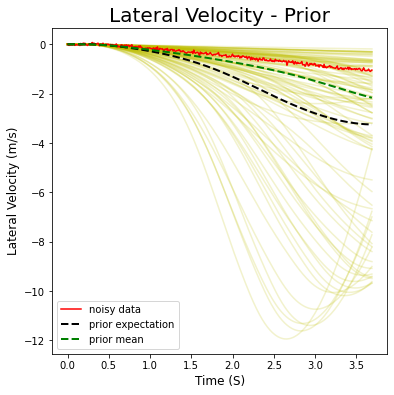

In [90]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,prior_LV[i,:],'y',alpha = 0.2)
   
mpl.plot(time,data[0,:],'r',label ='noisy data')
# mpl.plot(time,post_exp_LV,'k',linewidth = 2,label='posterior expectiation')
mpl.plot(time,prior_exp_LV,'k--',linewidth=2,label='prior expectation')
# mpl.plot(time,post_mean_LV,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_LV,'g--',linewidth=2,label='prior mean')
mpl.title("Lateral Velocity - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Lateral Velocity (m/s)',fontsize = 12)
mpl.legend()
if(save):
    mpl.savefig('./images/LV_st_prior_1.png',facecolor = 'w')


### Yaw rate

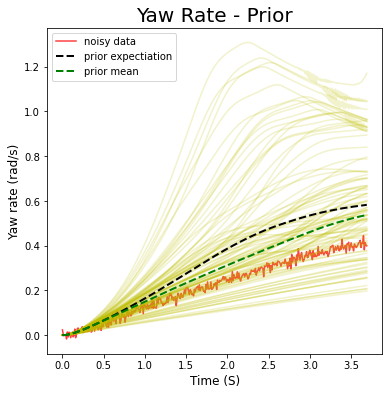

In [91]:
mpl.figure(figsize = (6,6))
mpl.plot(time,data[3,:],'r',label ='noisy data',alpha=0.75)
for i in range(0,no_post):
    mpl.plot(time,prior_YW[i,:],'y',alpha=0.2)

    
# mpl.plot(time,post_exp_YW,'k',linewidth = 2,label='posterior expectation')
mpl.plot(time,prior_exp_YW,'k--',linewidth=2,label='prior expectiation')
mpl.title("Yaw Rate - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Yaw rate (rad/s)',fontsize = 12)
# mpl.plot(time,post_mean_YW,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_YW,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/YR_st_prior_1.png',facecolor = 'w')

### Roll angle

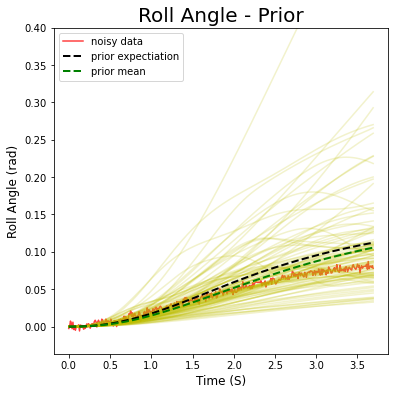

In [92]:
mpl.figure(figsize = (6,6))
mpl.plot(time,data[1,:],'r',label ='noisy data',alpha=0.75)
for i in range(0,no_post):
    mpl.plot(time,prior_RA[i,:],'y',alpha=0.2)

# mpl.plot(time,post_exp_RA,'k',linewidth = 2,label='posterior expectation')
mpl.plot(time,prior_exp_RA,'k--',linewidth=2,label='prior expectiation')
mpl.title("Roll Angle - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Roll Angle (rad)',fontsize = 12)
mpl.ylim(top=0.4)
# mpl.plot(time,post_mean_RA,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_RA,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/RA_st_prior_1.png',facecolor = 'w')

### Roll Rate

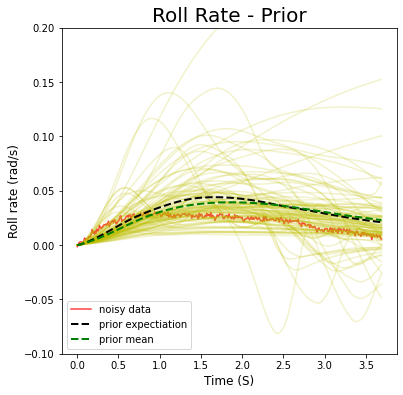

In [93]:
mpl.figure(figsize = (6,6))
mpl.plot(time,data[2,:],'r',label ='noisy data',alpha=0.75)
for i in range(0,no_post):
    mpl.plot(time,prior_RR[i,:],'y',alpha=0.2)

# mpl.plot(time,post_exp_RR,'k',linewidth = 2,label='posterior expectation')
mpl.plot(time,prior_exp_RR,'k--',linewidth=2,label='prior expectiation')
mpl.title("Roll Rate - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Roll rate (rad/s)',fontsize = 12)
mpl.ylim(bottom=-0.1,top=0.2)
# mpl.plot(time,post_mean_RR,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_RR,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/RR_st_prior_1.png',facecolor = 'w')

## Posteriors

### Lateral Velocity

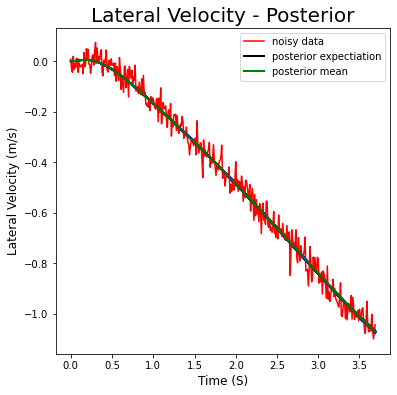

In [113]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,posterior_LV[i,:],'b',alpha=0.75)

# az.plot_hdi(time, hdi_data=hdi_LV, color="black", fill_kwargs={"label": "95% HDI"})
mpl.plot(time,data[0,:],'r',label ='noisy data')
mpl.plot(time,post_exp_LV,'k',linewidth = 2,label='posterior expectiation')
mpl.plot(time,post_mean_LV,'g',linewidth=2,label='posterior mean')
mpl.title("Lateral Velocity - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Lateral Velocity (m/s)',fontsize = 12)
mpl.legend()
if(save):
    mpl.savefig('./images/LV_st_post_1.png',facecolor = 'w')
#     mpl.savefig('./images/LV_st_post_nuts_1.png',facecolor = 'w')
# mpl.savefig('./images/LVbphi.png')

### Yaw rate psoterior

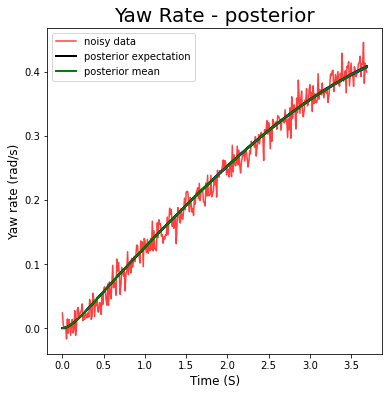

In [114]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,posterior_YW[i,:],'b',alpha=0.2)
mpl.plot(time,data[3,:],'r',label ='noisy data',alpha=0.75) 
mpl.plot(time,post_exp_YW,'k',linewidth = 2,label='posterior expectation')
# mpl.plot(time,prior_exp_YW,'k--',linewidth=2,label='prior expectiation')
mpl.title("Yaw Rate - posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Yaw rate (rad/s)',fontsize = 12)
mpl.plot(time,post_mean_YW,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_YW,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/YR_st_post_1.png',facecolor = 'w')
#     mpl.savefig('./images/YR_st_post_nuts_1.png',facecolor = 'w')
# mpl.savefig('./images/YRbphi.png')

### Roll angle prior

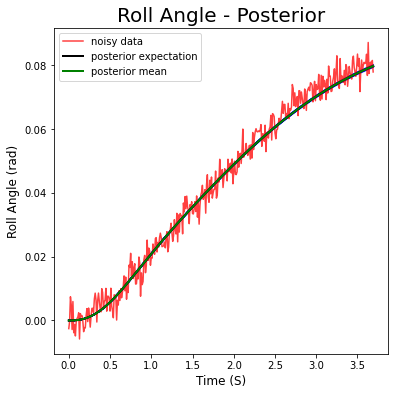

In [115]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,posterior_RA[i,:],'b',alpha=0.2)
mpl.plot(time,data[1,:],'r',label ='noisy data',alpha=0.75)

mpl.plot(time,post_exp_RA,'k',linewidth = 2,label='posterior expectation')
# mpl.plot(time,prior_exp_RA,'k--',linewidth=2,label='prior expectiation')
mpl.title("Roll Angle - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Roll Angle (rad)',fontsize = 12)
mpl.plot(time,post_mean_RA,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_RA,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/RA_st_post_1.png',facecolor = 'w')
#     mpl.savefig('./images/RA_st_post_nuts_1.png',facecolor = 'w')
# mpl.savefig('./images/RAbphi.png')

### Roll rate

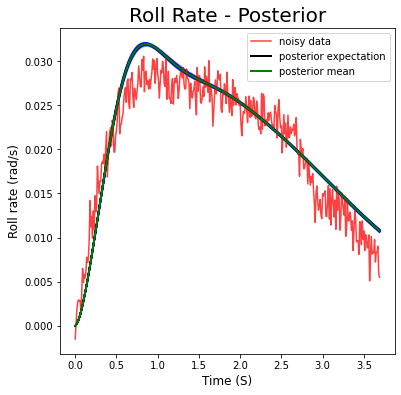

In [116]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,posterior_RR[i,:],'b',alpha=0.2)
mpl.plot(time,data[2,:],'r',label ='noisy data',alpha=0.75)
mpl.plot(time,post_exp_RR,'k',linewidth = 2,label='posterior expectation')
# mpl.plot(time,prior_exp_RR,'k--',linewidth=2,label='prior expectiation')
mpl.title("Roll Rate - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Roll rate (rad/s)',fontsize = 12)
mpl.plot(time,post_mean_RR,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_RR,'g--',linewidth=2,label='prior mean')
mpl.legend()
if(save):
    mpl.savefig('./images/RR_st_post_1.png',facecolor = 'w')
#     mpl.savefig('./images/RR_st_post_nuts_1.png',facecolor = 'w')
# mpl.savefig('./images/RRbphi.png')

In [98]:
posterior_LV.shape

(100, 370)

In [66]:
from scipy import stats

In [88]:
l = []
for line in posterior_LV:
    l.append(stats.gaussian_kde(line)(time))

In [89]:
l = np.array(l)
hdi = az.hdi(l, hdi_prob=0.95)

/tmp/ipykernel_1362825/3572473989.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(l, hdi_prob=0.95)


In [94]:
h = az.hdi(l, hdi_prob=0.95)

/tmp/ipykernel_1362825/2159057596.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  h = az.hdi(l, hdi_prob=0.95)


In [21]:
## 95% prof plots

In [48]:
hdi = az.hdi(posterior_LV, hdi_prob=0.95)

/tmp/ipykernel_1362825/82181225.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(posterior_LV, hdi_prob=0.95)


In [58]:
hdi_prior = az.hdi(prior_LV,hdi_prob=0.95)

/tmp/ipykernel_1362825/2380993640.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_prior = az.hdi(prior_LV,hdi_prob=0.95)


array([[<AxesSubplot:title={'center':'Cf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'Cr'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'krof'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'k'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'brof'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'bror'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'sigmaRA'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigmaRR'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'sigmaLV'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'sigmaYR'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'kror'}, xlabel='Rank (all chains)', ylabel='

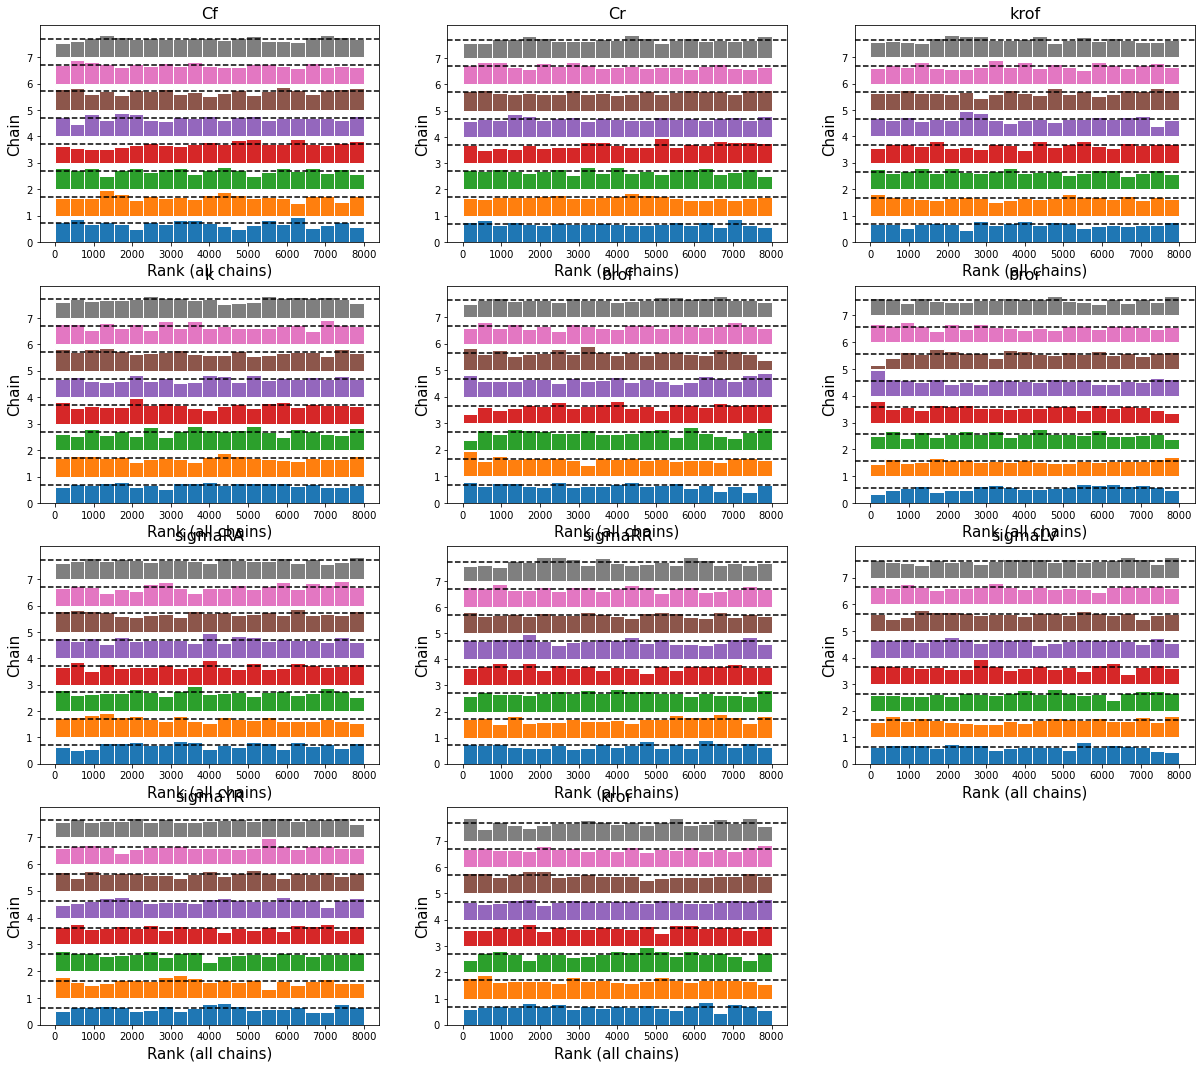

In [144]:
az.plot_rank(idata)

In [3]:
state['vx'][n1]

17.45082

### Plotting the steering input

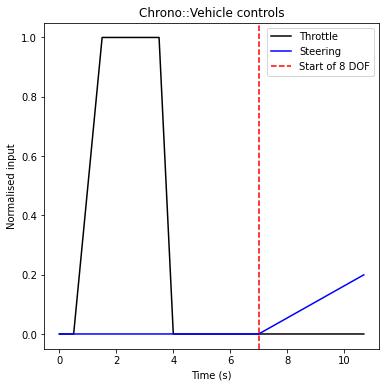

In [15]:
# A ramp steer
pt1 = Point(0,0)
pt2 = Point(7,0.)
pt3 = Point(10.7,0.2)
ramp_st_3 = pt1.get_eq(pt2)
ramp_st_4 = pt2.get_eq(pt3)

def ramp_st(t):
    if(t<7):
        return ramp_st_3(t)
    else:
        return ramp_st_4(t)
    
tpt1 = Point(0.5,0)
tpt2 = Point(1.5,1)
tpt3 = Point(3.5,1)
tpt4 = Point(4,0)
tpt5 = Point(10.7,0)

th_1 = tpt1.get_eq(tpt2)
th_2 = tpt2.get_eq(tpt3)
th_3 = tpt3.get_eq(tpt4)
th_4 = tpt4.get_eq(tpt5)

    
def throt(t):
    if(t<0.5):
        return 0
    elif(t < 1.5):
        return th_1(t)
    elif(t < 3.5):
        return th_2(t)
    elif(t < 4):
        return th_3(t)
    else:
        return th_4(t)

# The time duration of the simulation
st_time = 0.
end_time = 10.7


# The times for which we want the simulation
time  = np.arange(st_time,end_time,0.01)
t_eval = np.arange(st_time,end_time,0.01)

th = []
s = []
for t in t_eval:
    th.append(throt(t))
    s.append(ramp_st(t))

mpl.figure(figsize = (6,6))
mpl.plot(t_eval,th,'k',t_eval,s,'b')
mpl.axvline(x=7,color='r',ls='--',label='Start of 8 DOF')
mpl.legend(['Throttle','Steering','Start of 8 DOF'])
mpl.xlabel('Time (s)')
mpl.ylabel('Normalised input')
mpl.title('Chrono::Vehicle controls')
mpl.savefig('./images/lat_input.png',facecolor = 'w')
mpl.show()



In [99]:
msae_post_LV = np.mean(np.sqrt((np.sum((posterior_LV - data[0,:])**2,axis=1)/data.shape[1])))

In [100]:
msae_post_LV

0.03657616129624917

In [101]:
msae_prior_LV = np.mean(np.sqrt((np.sum((prior_LV - data[0,:])**2,axis=1)/data.shape[1])))

In [102]:
msae_prior_LV

1.397577276198546

In [103]:
msae_post_RA = np.mean(np.sqrt((np.sum((posterior_RA - data[1,:])**2,axis=1)/data.shape[1])))

In [104]:
msae_post_RA

0.003271485685231961

In [105]:
msae_prior_RA = np.mean(np.sqrt((np.sum((prior_RA - data[1,:])**2,axis=1)/data.shape[1])))

In [106]:
msae_prior_RA

0.026678893514663474

In [107]:
msae_post_RR = np.mean(np.sqrt((np.sum((posterior_RR - data[2,:])**2,axis=1)/data.shape[1])))

In [108]:
msae_post_RR

0.0025732884347547695

In [109]:
msae_prior_RR = np.mean(np.sqrt((np.sum((prior_RR - data[2,:])**2,axis=1)/data.shape[1])))

In [110]:
msae_prior_RR

0.020557546466948913

In [111]:
msae_post_YW = np.mean(np.sqrt((np.sum((posterior_YW - data[3,:])**2,axis=1)/data.shape[1])))

In [112]:
msae_post_YW

0.014666483265682548

In [39]:
msae_prior_YW = np.mean(np.sqrt((np.sum((prior_YW - data[3,:])**2,axis=1)/data.shape[1])))

In [40]:
msae_prior_YW

0.16199912308468103